In [1]:
import numpy as np
import pandas as pd
import matplotlib
import random
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure6/output_fig6/'


from scripts.io_library import MyLib
from scripts.clustering_utils import Clustering
from scripts.utils import Utils
from scripts.visualization import MyVisualization

In [2]:
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
proteomics_file = 'Main_Data/Proteomics/proteomics_collapsed.csv'
raw_proteomics_df = MyLib.load_csv(proteomics_file, index_col=0)
raw_proteomics_df = raw_proteomics_df.T

proteomics_df = Clustering.filter_sparse_samples(raw_proteomics_df, max_allowed_nans_zeros_frac=0.1)

upset_file = 'cell_lines_master_upset_2025-2-24.csv'
raw_upset_df = MyLib.load_csv(upset_file, index_col=0)
upset_df = raw_upset_df[raw_upset_df['Protein']==1]
upset_df = upset_df[["Subtype"]]
upset_df = upset_df.loc[proteomics_df.index, :]
print('proteomics_df shape', proteomics_df.shape)

input_data/Main_Data/Proteomics/proteomics_collapsed.csv  is loaded, shape:  (14411, 75)

input_data/cell_lines_master_upset_2025-2-24.csv  is loaded, shape:  (87, 11)

proteomics_df shape (75, 5299)


In [4]:
top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
upset_mut_df = pd.concat([upset_df, top_mut_df.loc[upset_df.index, :]], axis=1)
upset_mut_df = upset_mut_df[["FGFR2$","BAP1$", "IDH1/2$","BRAF$","SMAD4$", "KRAS$", "TP53$" ]]
# upset_df = pd.concat([upset_df, upset_mut_df], axis=1)

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)



In [5]:
RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)
upset_df['RNA_Cluster'] = RNA_upset_df['RNA_Cluster']
upset_df = pd.concat([upset_df, upset_mut_df], axis=1)

In [6]:
upset_df

,Subtype,RNA_Cluster,FGFR2$,BAP1$,IDH1/2$,BRAF$,SMAD4$,KRAS$,TP53$
CCLP1,ICC,R1,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE
CCSW1,ICC,R4,NaN,NaN,NaN,NaN,Het_loss,NaN,MISSENSE
AOVC1,AC,R4,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE
ECC3,ECC,R4,NaN,NaN,NaN,NaN,SPLICE_SITE,NaN,MISSENSE
EGI1,ECC,R4,NaN,NaN,NaN,NaN,NaN,MISSENSE,MISSENSE
...,...,...,...,...,...,...,...,...,...
TGBC1TKB,GBC,R4,NaN,NaN,NaN,NaN,NaN,NaN,FRAME_SHIFT_INS
TGBC52TKB,AC,R1,NaN,NaN,NaN,NaN,NaN,MISSENSE,NaN
TKKK,ICC,R4,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE
TONG,HCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(len(upset_df))
upset_df[upset_df['Subtype']=='HCC'].shape

75


(17, 9)

# Clustering

In [7]:
proteomics_mad_df = proteomics_df.apply(Clustering.mad_normalize)
corr_proteomics_mad_df = proteomics_mad_df.transpose().corr()

In [8]:
# MyLib.save_csv(proteomics_mad_df, 'proteomics_collapsed_filtered_mad_normalized.csv')

## Plot with borders


File  Figure6/output_fig6/all_P1_features_Up.csv saved, shape: (644, 4)

File  Figure6/output_fig6/P1_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P2_features_Up.csv saved, shape: (605, 4)

File  Figure6/output_fig6/P2_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P3_features_Up.csv saved, shape: (817, 4)

File  Figure6/output_fig6/P3_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P4_features_Up.csv saved, shape: (224, 4)

File  Figure6/output_fig6/P4_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P5_features_Up.csv saved, shape: (267, 4)

File  Figure6/output_fig6/P5_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/Protein_reordered_upset_df.csv saved, shape: (75, 3)


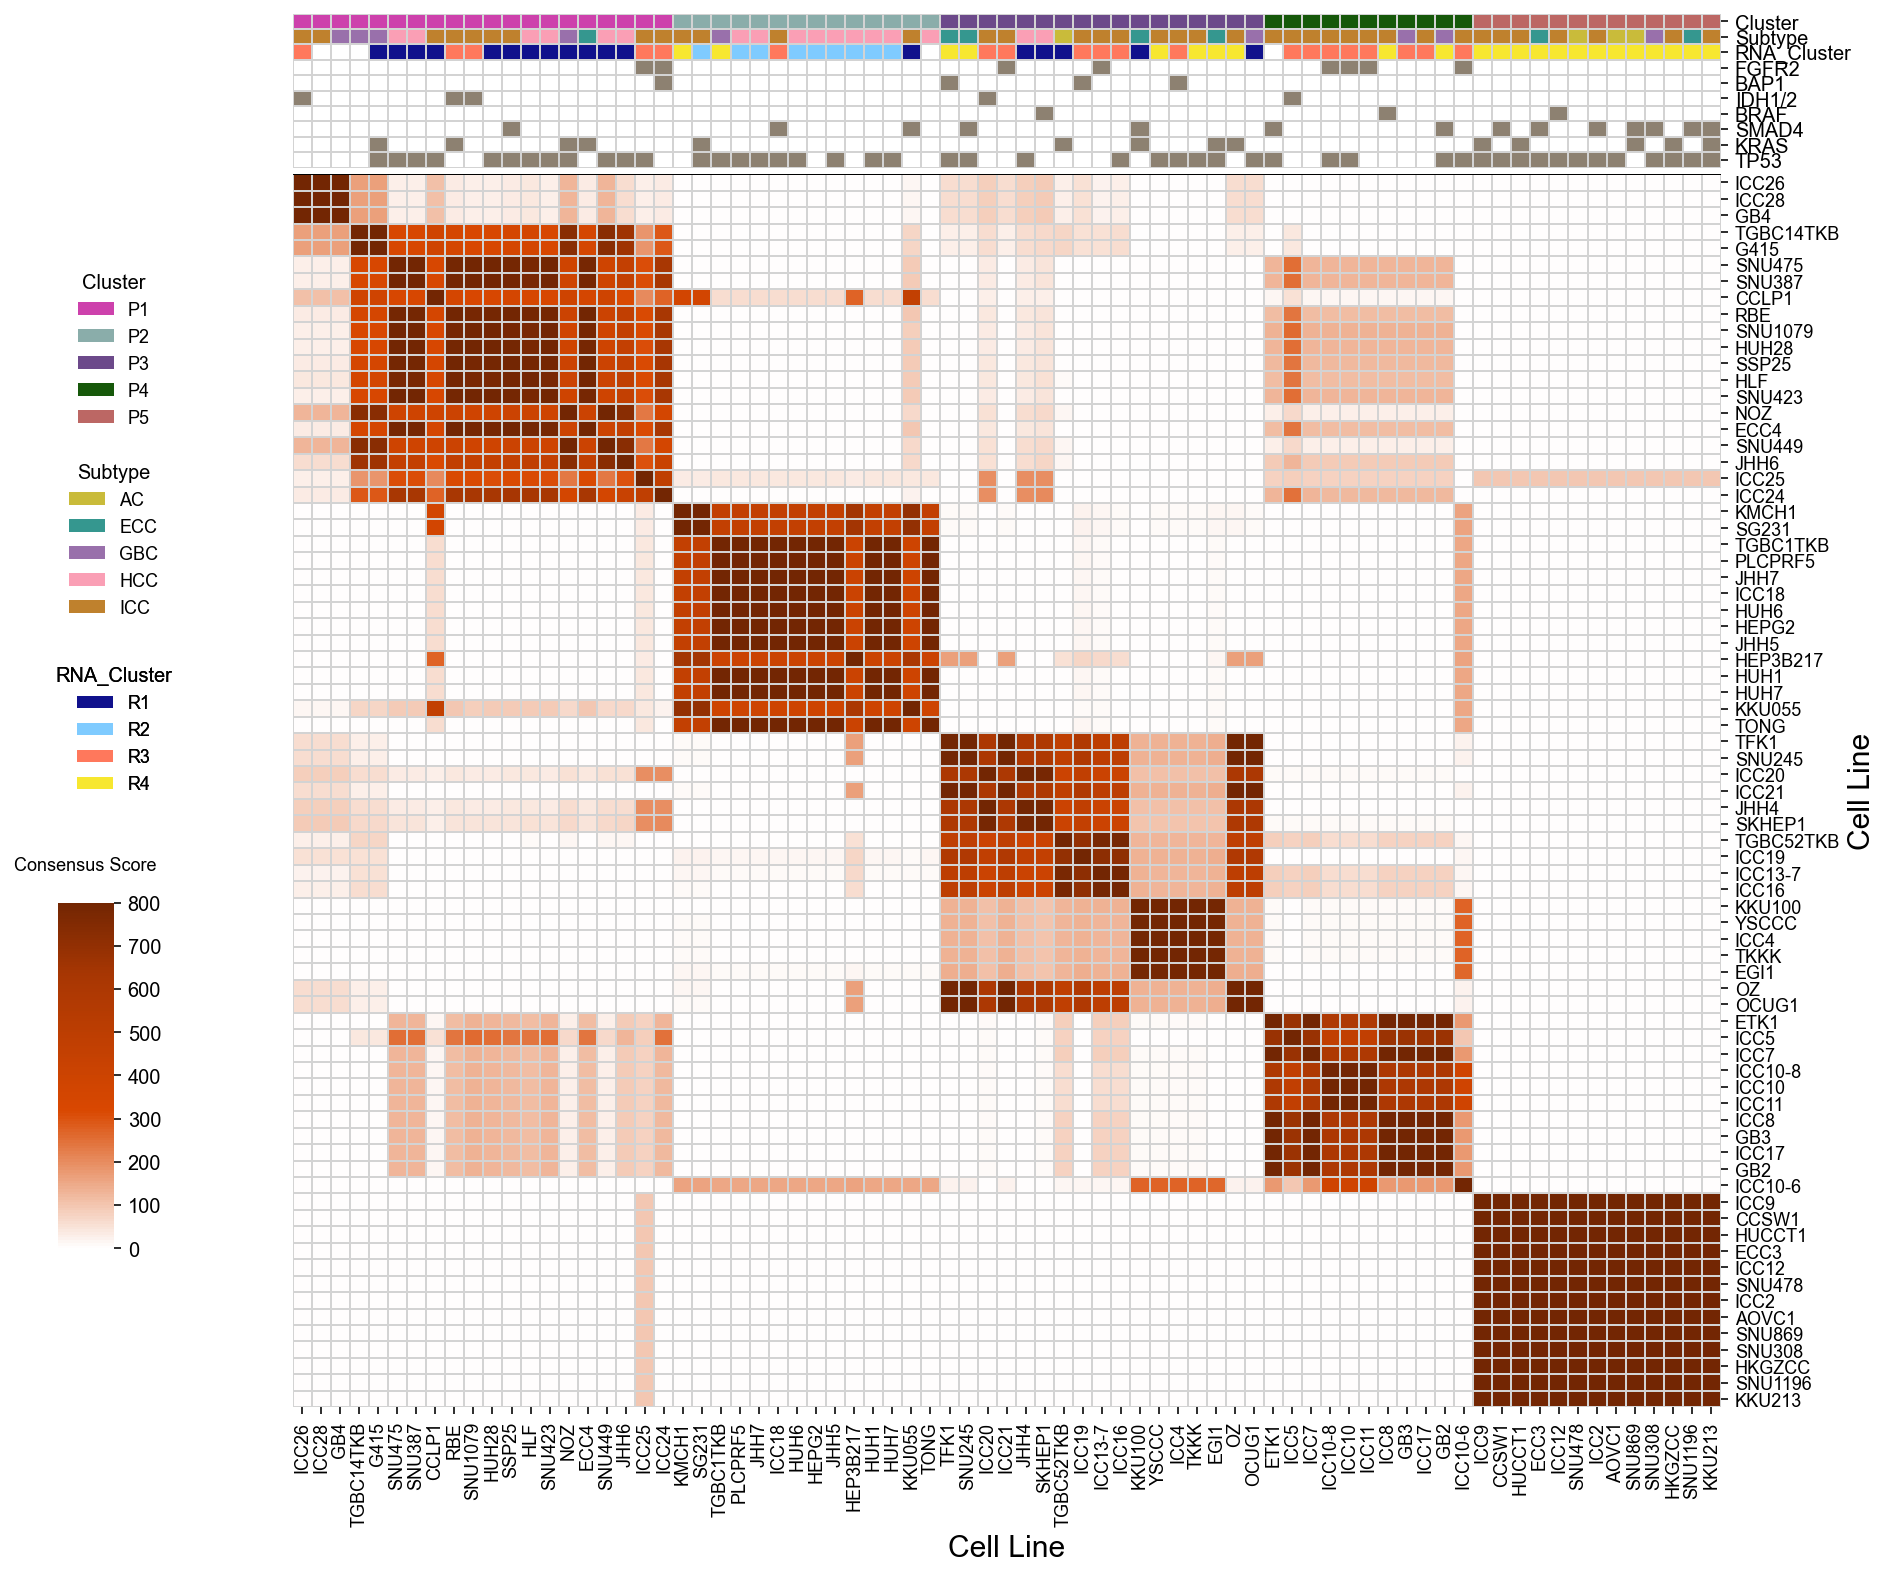

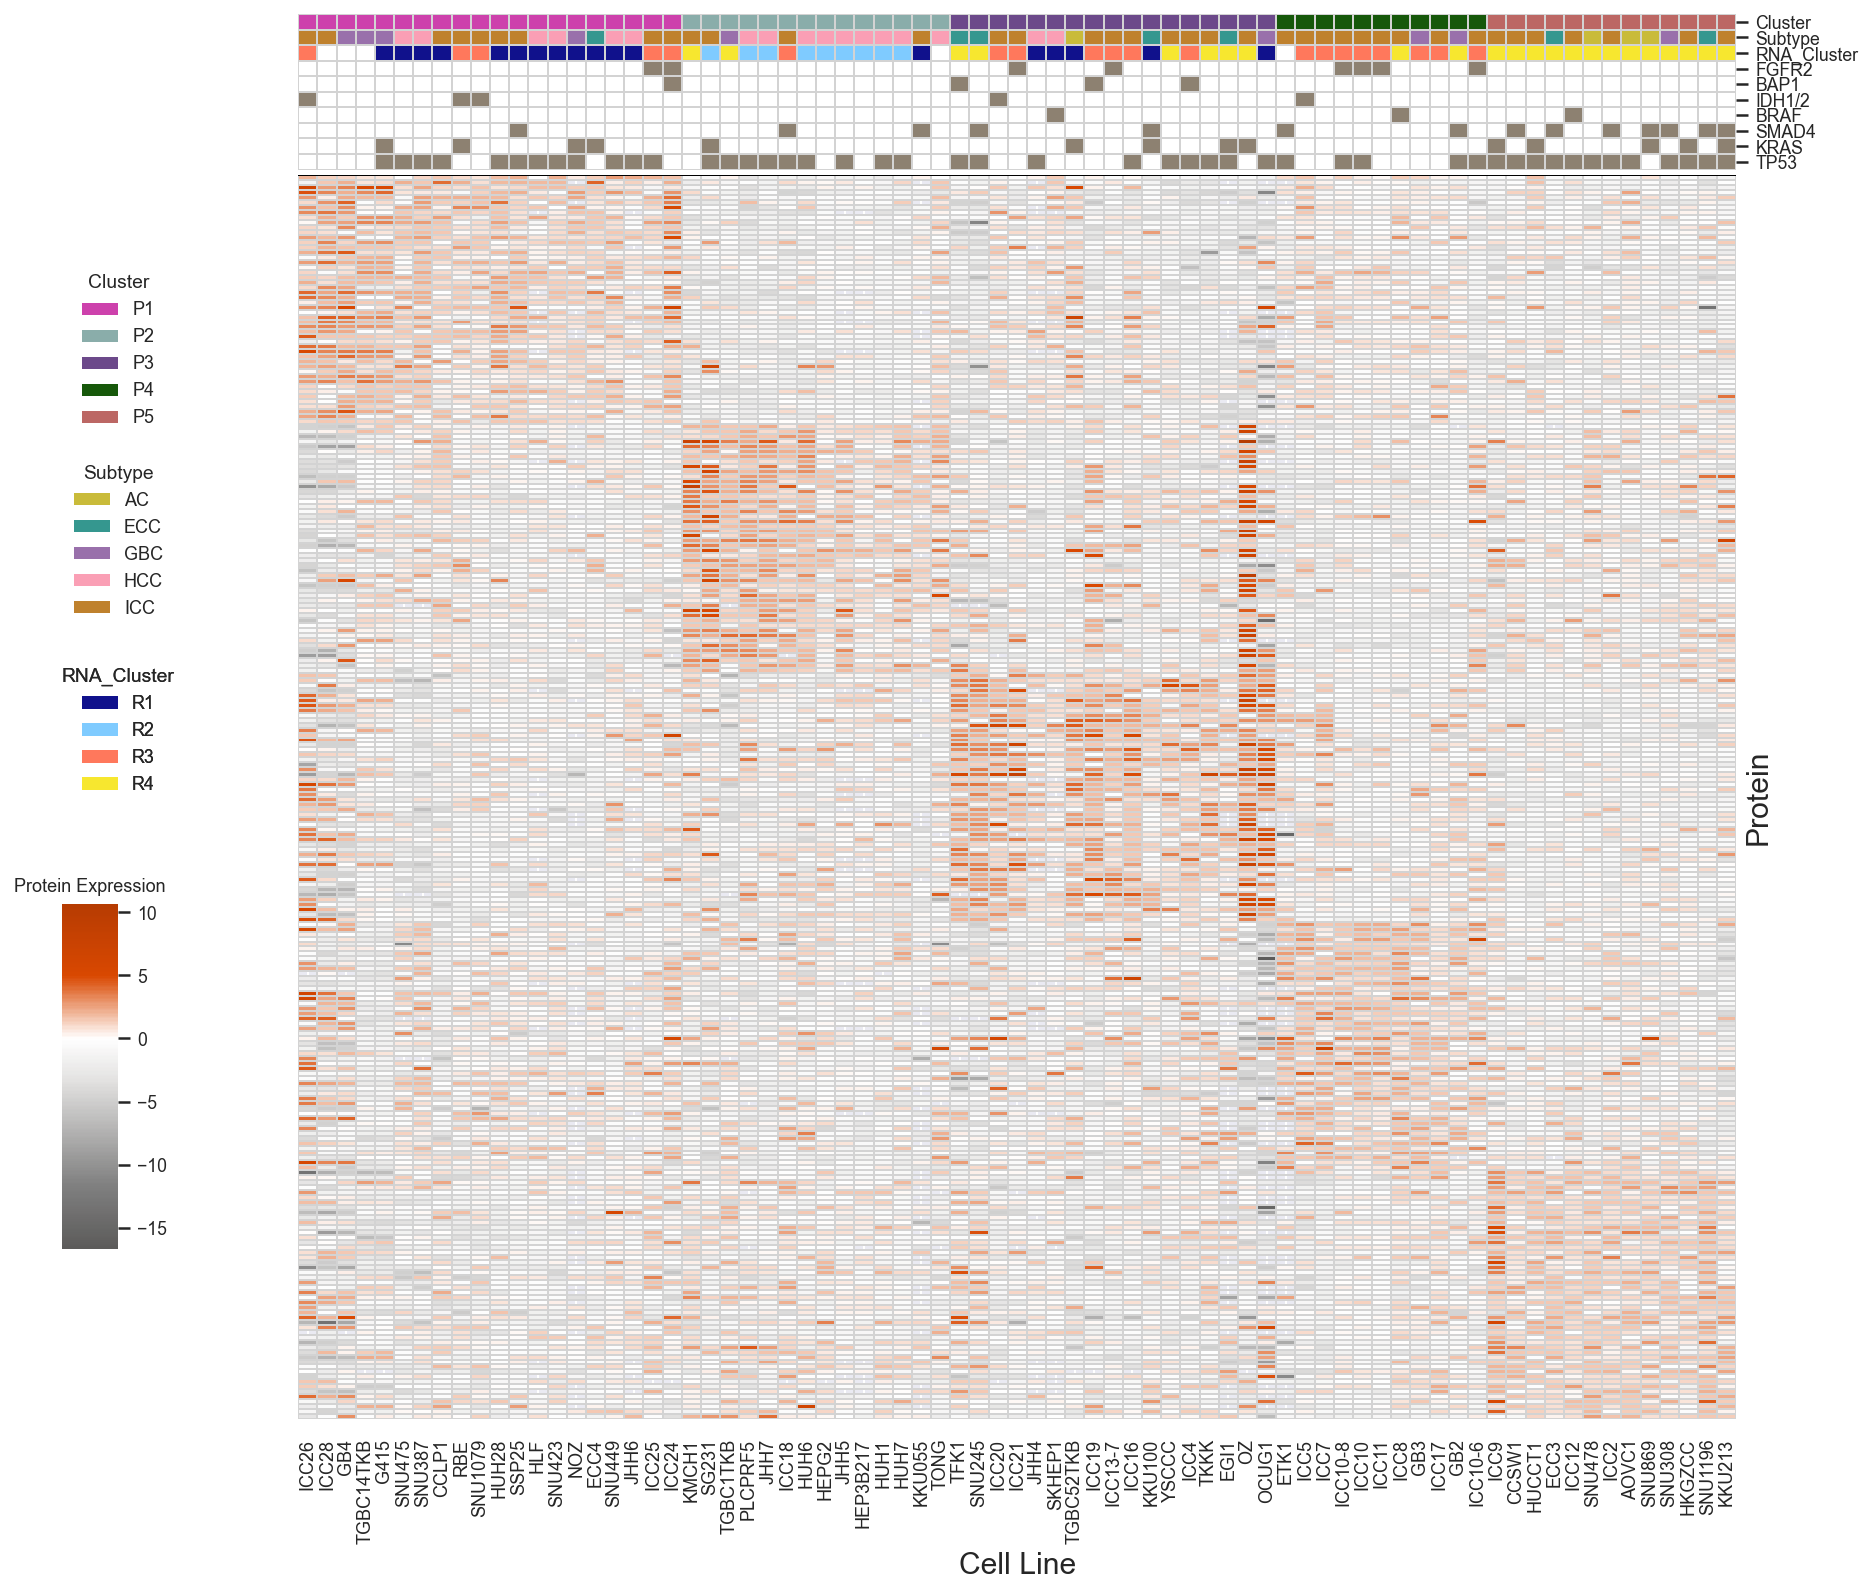

In [9]:
gammas =  [.8, 1, 1.2, 1.4]
labels_np, consensus_ite = Clustering.louvain_clustering_ensemble(corr_proteomics_mad_df, ite=200, gammas=gammas)
# up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(proteomics_mad_df, corr_proteomics_mad_df, upset_df, labels_np, consensus_ite, row_label='Protein', plot_volcano=False, yticklabels=False, feature_cutoff=50, event_legend = False, event_color='#8D0741', cbar_title=f"Protein Expression", cbar_left_adjust=0.03, left_adjust=0.07, legend_top_offset=0.7, borders_linewidths=0, cluster_prefix='P')

clusters_reordering = [1, 5,3,4,2] # ite 2000
up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(proteomics_mad_df, corr_proteomics_mad_df, upset_df, labels_np, consensus_ite, row_label='Protein', clusters_reordering=clusters_reordering,  bar_colors_ratio=0.01, feature_cutoff=50, event_legend = False, event_color='#8D8171', yticklabels=False,  cbar_title="Protein Expression", cbar_left_adjust=0.03, left_adjust=0.07, legend_top_offset=0.7, cluster_prefix='P', save_figure=True)

## No border


File  Figure6/output_fig6/all_P1_features_Up.csv saved, shape: (644, 4)

File  Figure6/output_fig6/P1_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P2_features_Up.csv saved, shape: (605, 4)

File  Figure6/output_fig6/P2_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P3_features_Up.csv saved, shape: (817, 4)

File  Figure6/output_fig6/P3_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P4_features_Up.csv saved, shape: (224, 4)

File  Figure6/output_fig6/P4_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/all_P5_features_Up.csv saved, shape: (267, 4)

File  Figure6/output_fig6/P5_features_Up.csv saved, shape: (50, 3)

File  Figure6/output_fig6/Protein_reordered_upset_df.csv saved, shape: (75, 3)


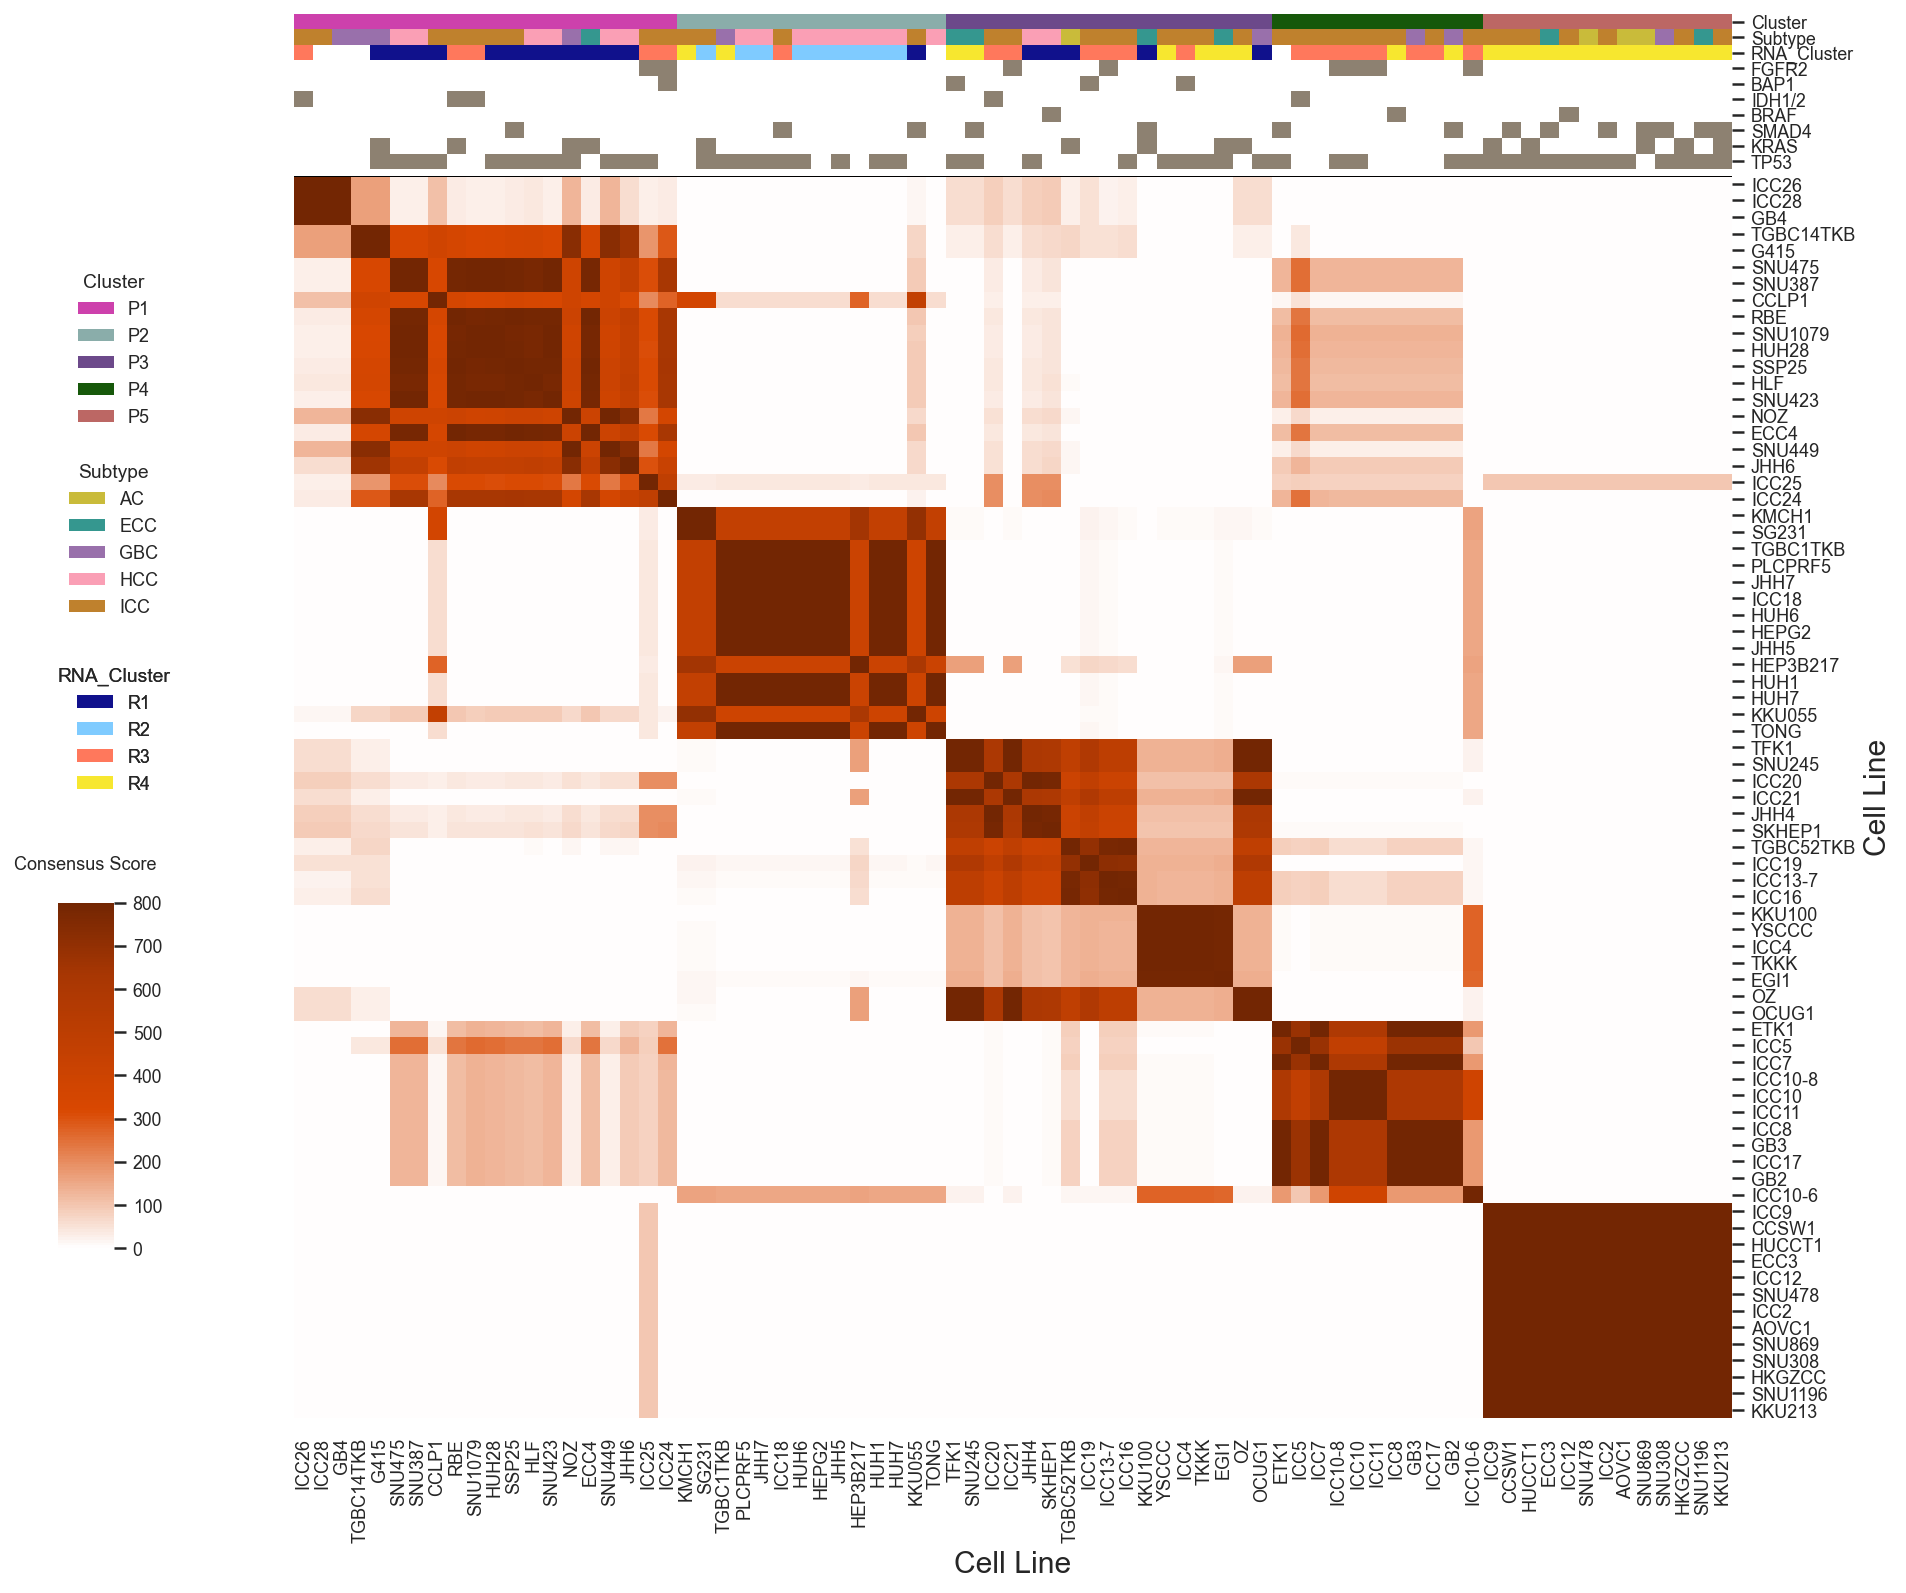

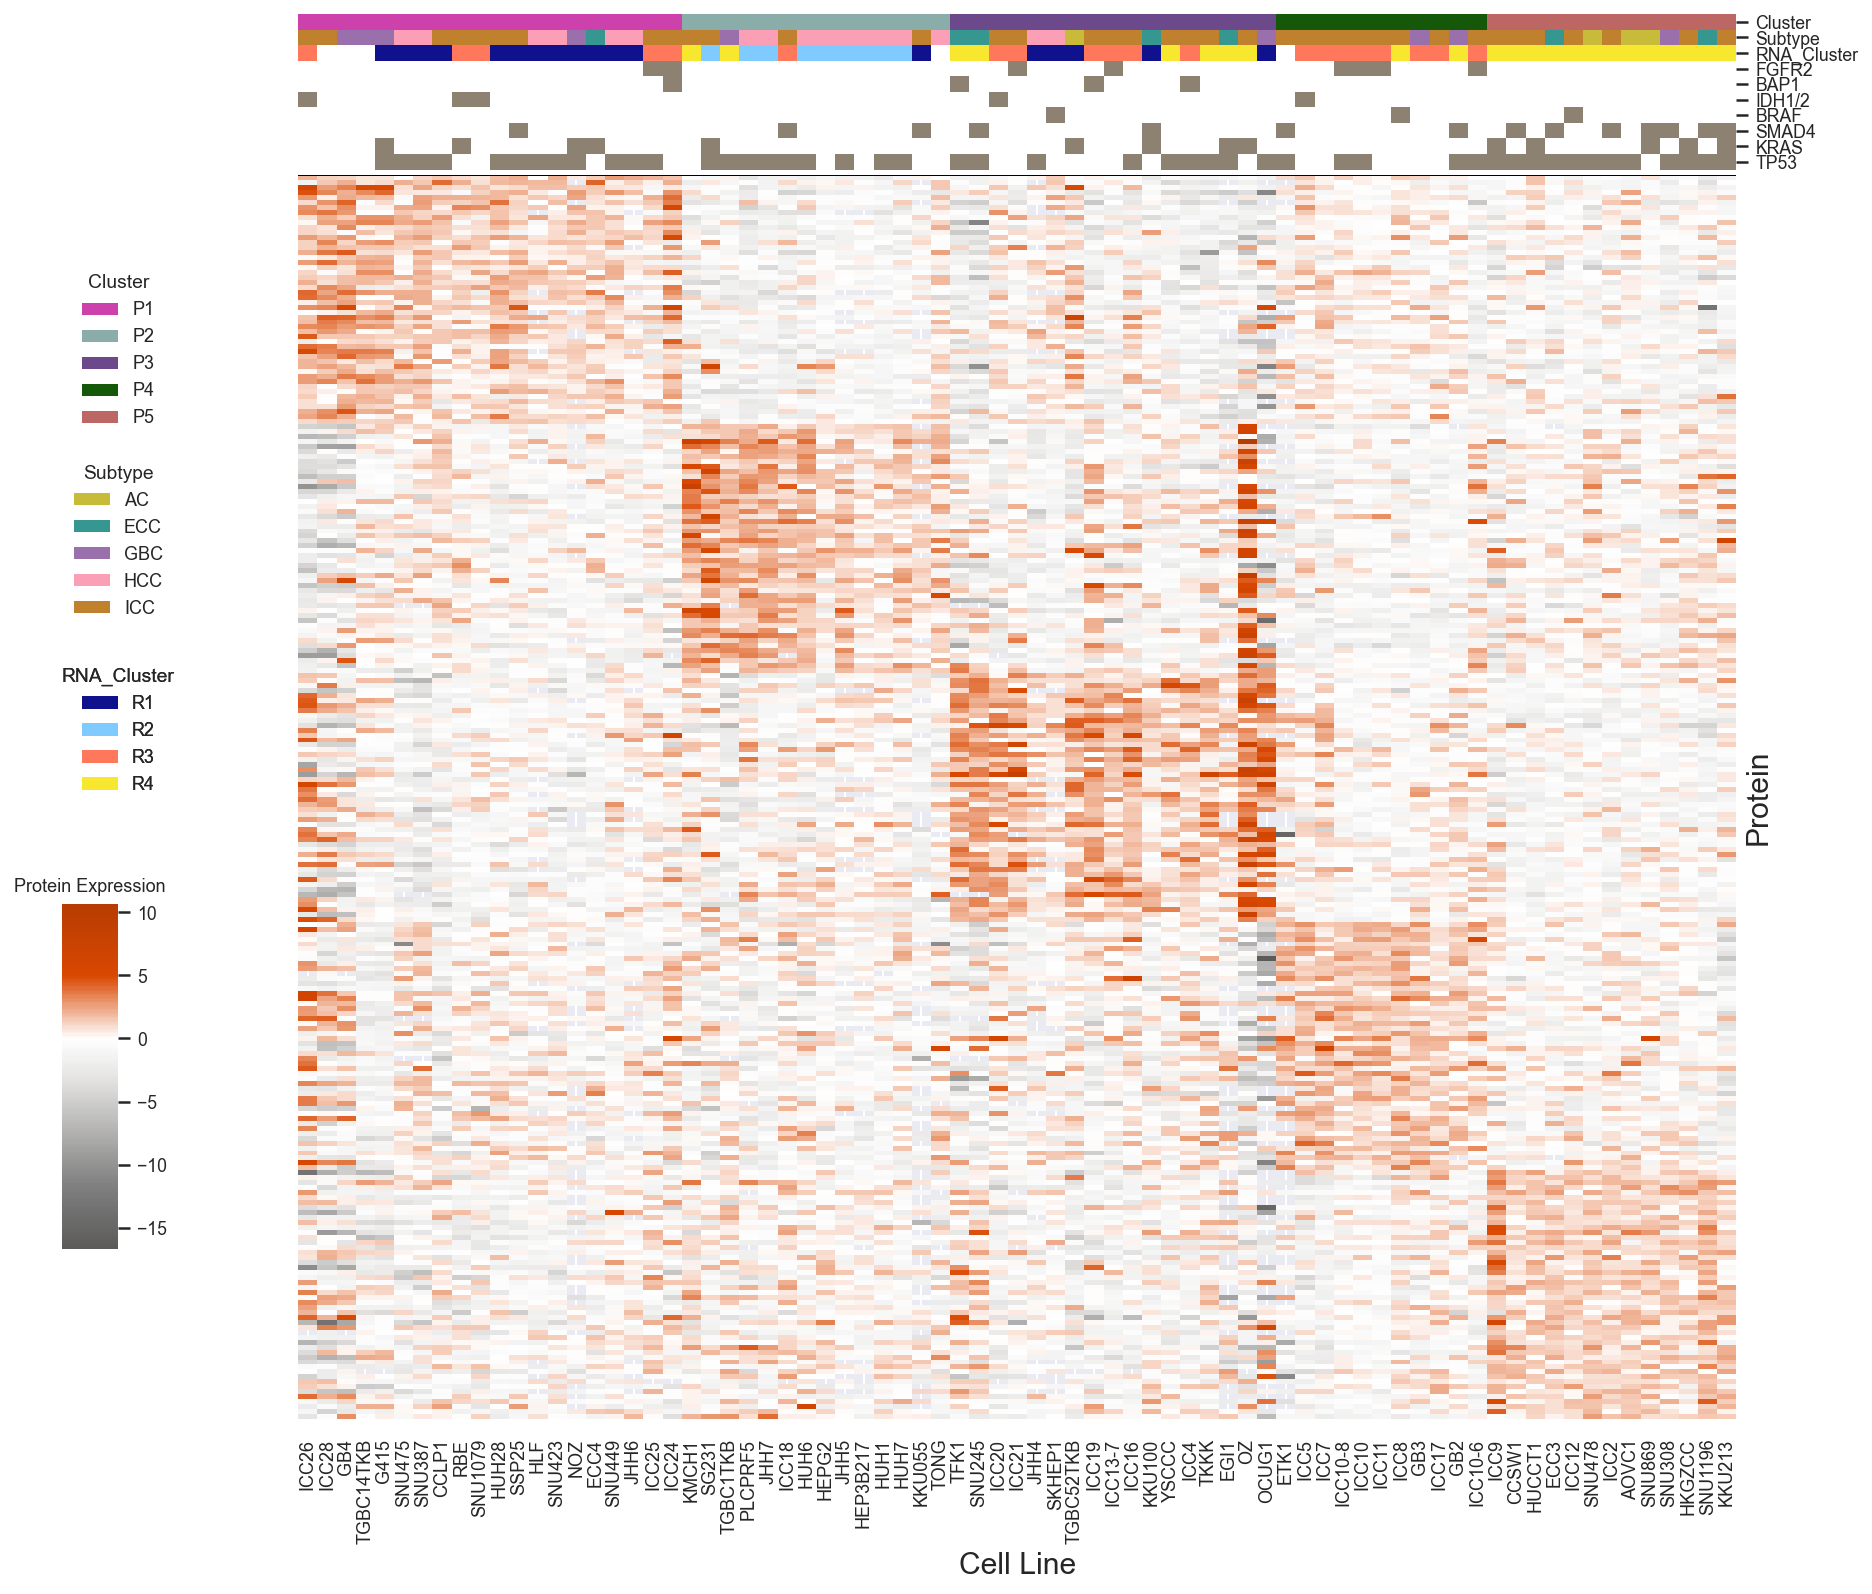

In [10]:
gammas =  [.8, 1, 1.2, 1.4]
labels_np, consensus_ite = Clustering.louvain_clustering_ensemble(corr_proteomics_mad_df, ite=200, gammas=gammas)
# up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(proteomics_mad_df, corr_proteomics_mad_df, upset_df, labels_np, consensus_ite, row_label='Protein', plot_volcano=False, yticklabels=False, feature_cutoff=50, event_legend = False, event_color='#8D0741', cbar_title=f"Protein Expression", cbar_left_adjust=0.03, left_adjust=0.07, legend_top_offset=0.7, borders_linewidths=0)

clusters_reordering = [1, 5,3,4,2] # ite 2000
up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(proteomics_mad_df, corr_proteomics_mad_df, upset_df, labels_np, consensus_ite, row_label='Protein', clusters_reordering=clusters_reordering,plot_volcano=False, yticklabels=False, feature_cutoff=50, event_legend = False, event_color='#8D8171', cbar_title=f"Protein Expression", cbar_left_adjust=0.03, left_adjust=0.07, legend_top_offset=0.7, borders_linewidths=0, cluster_prefix='P', save_figure=True)

# Adjusted Rand Index analysis

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)

P1
P2
P3
P4
P5

File  Figure6/output_fig6/adjusted_rand_index_stats_protein_clustering.csv saved, shape: (36, 5)

File  Figure6/output_fig6/adjusted_rand_scores_Clustering Similaritiesprotein_clustering.csv saved, shape: (36, 5)


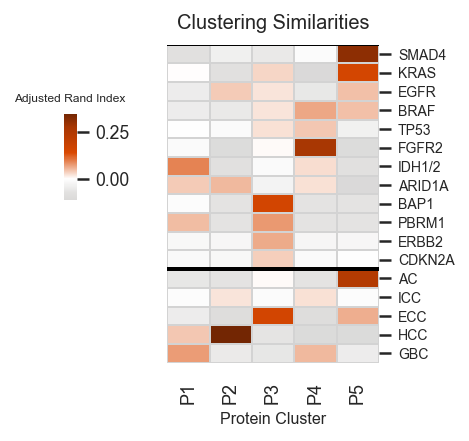

(            P1      P2      P3      P4      P5
 SMAD4    0.993   0.793   0.882  0.6498  0.0018
 KRAS    0.5564  0.9592  0.4062     1.0   0.054
 EGFR       1.0  0.4562  0.5434     1.0  0.4476
 BRAF       1.0     1.0  0.5522  0.3754  0.4298
 TP53    0.4956  0.6642  0.2634  0.1682  0.9458
 FGFR2   0.6854     1.0  0.5752   0.014     1.0
 IDH1/2  0.1068     1.0  0.7502  0.5446     1.0
 ARID1A   0.323  0.3372  0.7646  0.5036     1.0
 BAP1    0.7102     1.0   0.032     1.0     1.0
 PBRM1   0.2846     1.0  0.2298     1.0     1.0
 ERBB2      1.0     1.0  0.2204     1.0     1.0
 CDKN2A   0.846     1.0   0.113  0.7906  0.4964
 AC         1.0     1.0  0.6636     1.0  0.0134
 ICC     0.6158   0.082     1.0  0.0428     1.0
 ECC      0.895     1.0   0.041     1.0    0.35
 HCC      0.262  0.0002  0.9456     1.0     1.0
 GBC     0.1816  0.8576  0.9128  0.3804  0.8388,
               P1     P2      P3      P4      P5
 SMAD4        1.0    1.0     1.0     1.0   0.108
 KRAS         1.0    1.0     1.0     

In [11]:
protein_upset_file = 'Figure6/output_fig6/Protein_reordered_upset_df.csv'
protein_upset_df = pd.read_csv(protein_upset_file, index_col=0)

top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
feat_df = top_mut_df.loc[protein_upset_df.index, ]
feat_df.columns = [c.replace('$', '') for c in feat_df.columns]
feat_df = feat_df.fillna(0)

for f in feat_df.columns:
    feat_df[f] = feat_df[f].apply(lambda x:1 if x!=0 else 0)
for c in protein_upset_df['Subtype'].unique():
    feat_df[c] = protein_upset_df['Subtype'].apply(lambda x:1 if x==c else 0)
feats = ['SMAD4', 'KRAS','EGFR', 'BRAF', 'TP53',  'FGFR2','IDH1/2', 'ARID1A', 'BAP1', 'PBRM1',  'ERBB2','CDKN2A',  'AC', 'ICC','ECC', 'HCC', 'GBC' ]
feat_df = feat_df[feats]
clusters_df = pd.DataFrame(0, index=protein_upset_df.index, columns=sorted(protein_upset_df['Cluster'].unique()))
for c in clusters_df.columns:
    clusters_df[c] = protein_upset_df['Cluster'].apply(lambda x:1 if x==c else 0)
# Clustering.clustering_scores(clusters_df, feat_df, split_row=[12], col_label='Protein Cluster', save_figure=True)
Clustering.clustering_scores_and_statistics(clusters_df, feat_df, split_feats_l=['GBC', 'AC', 'ECC','ICC','HCC'], split_row=[12], col_label='Protein Cluster', save_figure=True, filename='protein_clustering')

P1
P2
P3
P4
P5

File  Figure6/output_fig6/adjusted_rand_index_stats_protein_rna_clustering_comparison.csv saved, shape: (10, 5)

File  Figure6/output_fig6/adjusted_rand_scores_protein_rna_clustering_comparison.csv saved, shape: (10, 5)


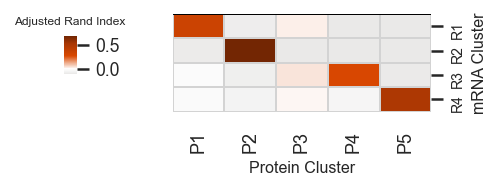

(        P1      P2      P3      P4      P5
 R1  0.0002  0.9846  0.3706     1.0     1.0
 R2     1.0  0.0002     1.0     1.0     1.0
 R3  0.6824  0.9922  0.2724  0.0004     1.0
 R4  0.6432  0.9716  0.4296   0.915  0.0002,
           P1        P2   P3     P4        P5
 R1  0.001333       1.0  1.0    1.0       1.0
 R2       1.0  0.001333  1.0    1.0       1.0
 R3       1.0       1.0  1.0  0.002       1.0
 R4       1.0       1.0  1.0    1.0  0.001333)

In [12]:
protein_rna_upset_df = protein_upset_df[['RNA_Cluster']]
protein_rna_upset_df = protein_rna_upset_df.dropna(axis=0)
clusters_df2 = clusters_df.loc[protein_upset_df.index, :]
rna_feat_df = pd.DataFrame(index=protein_upset_df.index)
for c in sorted(protein_rna_upset_df['RNA_Cluster'].unique()):
    rna_feat_df[c] = protein_upset_df['RNA_Cluster'].apply(lambda x:1 if x==c else 0)
Clustering.clustering_scores_and_statistics(clusters_df2, rna_feat_df, col_label='Protein Cluster', row_label='mRNA Cluster', title='', figsize_w=3, figsize_h=1.3, save_figure=True, filename='protein_rna_clustering_comparison')

# Robustness Analysis

### Downsampling

In [13]:
gammas =  [.8, 1, 1.2, 1.4]
sample_fractions_l = [.80, .75, .70, .65 , .60]
labels_dic = Clustering.run_louvain_on_multiple_subsamples(proteomics_mad_df, gammas=gammas, sample_fractions_l=sample_fractions_l, filename='Protein')
# labels_dic = MyLib.load_pkl(f'Figure6/output_fig6/Protein_subsampling_labels_dic.pkl')

started 50 runs with fraction 0.8
started 50 runs with fraction 0.75
started 50 runs with fraction 0.7
started 50 runs with fraction 0.65
started 50 runs with fraction 0.6

File  Figure6/output_fig6/Protein_subsampling_labels_dic.pkl saved, data size:  5



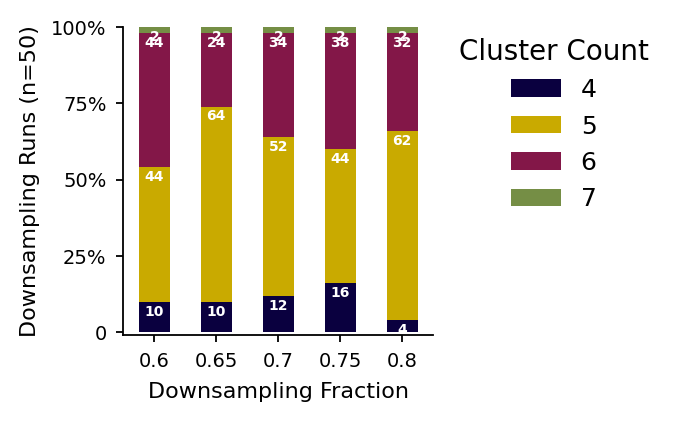

In [14]:
Clustering.louvain_clustering_stability_analysis(labels_dic, filename='Protein_Donwsampling')

<Figure size 400x200 with 0 Axes>

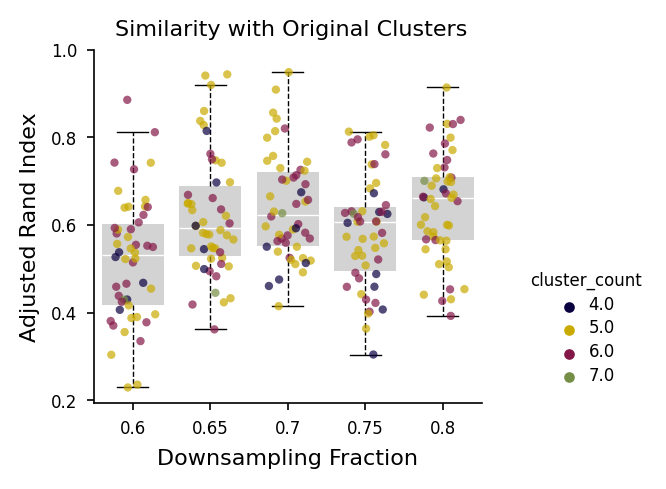

In [15]:
protein_upset_file = 'Figure6/output_fig6/Protein_reordered_upset_df.csv'
protein_upset_df = pd.read_csv(protein_upset_file, index_col=0)
protein_cluster_sr = protein_upset_df['Cluster']

frac_color_dic = {frac:'lightgray' for frac in sorted(sample_fractions_l)}
Clustering.adjust_rand_index_downsampling_comparisons(protein_cluster_sr, labels_dic, frac_color_dic, original_cluster_count=4,  ylim_top=1, filename='Protein_Donwsampling')

# Load Gene Effect

In [16]:
protein_upset_file = 'Figure6/output_fig6/Protein_reordered_upset_df.csv'
protein_upset_df = pd.read_csv(protein_upset_file, index_col=0)

gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
raw_gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
raw_gene_effect_df = raw_gene_effect_df.T
raw_gene_effect_df = raw_gene_effect_df.dropna(axis=1)
raw_gene_effect_df.columns = raw_gene_effect_df.columns.map(lambda x: str(x).split(' (')[0])

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
genes_exclude = [g.split(' (')[0] for g in genes_exclude]
gene_effect_df = raw_gene_effect_df.loc[:, ~raw_gene_effect_df.columns.isin(genes_exclude)]
# gene_effect_df = gene_effect_df.rename(columns={c:c.split(' (')[0] for c in gene_effect_df.columns})

protein_CRISPR_upset_df = protein_upset_df.loc[protein_upset_df.index.isin(gene_effect_df.index)]
print(gene_effect_df.shape)
print(protein_CRISPR_upset_df.shape)

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)

(60, 15308)
(52, 3)


# Correlation: Protein-Gene Effect

In [17]:
protein_gene_mapping_file = 'Additional_Data/Selected_Lists/protein_gene_mapping.csv'
protein_gene_mapping_df = MyLib.load_csv(protein_gene_mapping_file, index_col=0)
gp = protein_gene_mapping_df.groupby('GeneName')
count =0
for i, df in gp:
    if df.shape[0] > 1:
        # print(i, df.shape[0])
        count +=1
print('Number of genes mapped to multiple proteins:', count)

input_data/Additional_Data/Selected_Lists/protein_gene_mapping.csv  is loaded, shape:  (11421, 1)

Number of genes mapped to multiple proteins: 523


In [18]:
proteomics_file = 'Main_Data/Proteomics/proteomics_collapsed.csv'
proteomics_df = MyLib.load_csv(proteomics_file, index_col=0)
proteomics_df = proteomics_df.T
proteomics_df = proteomics_df.dropna(axis=1, how ='all')

proteomics_filtered_df, gene_effect_filtered_df = Utils.match_rows_df(proteomics_df, gene_effect_df)
proteomics_filtered_df = Clustering.filter_sparse_samples(proteomics_filtered_df, max_allowed_nans_zeros_frac=0.4)
proteomics_mad_filtered_df = proteomics_filtered_df.apply(Clustering.mad_normalize)

input_data/Main_Data/Proteomics/proteomics_collapsed.csv  is loaded, shape:  (14411, 75)



Gene effect data naming does not match the protein names. Moreover, the same gene can correspond to multiple proteins. First, select the corresponding protein-gene pairs from both the CRISPR and Protein data. Then, rename the gene names of the columns in the CRISPR data to match the protein names.

In [19]:
shared_proteins = [p for p in protein_gene_mapping_df.index if (p in proteomics_mad_filtered_df.columns) & (protein_gene_mapping_df.loc[p, 'GeneName'] in gene_effect_filtered_df.columns)]
protein_gene_mapping_filtered_df = protein_gene_mapping_df.loc[shared_proteins]
proteomics_mad_filtered_df = proteomics_mad_filtered_df[protein_gene_mapping_filtered_df.index]
genes_l = [protein_gene_mapping_filtered_df.loc[p, 'GeneName'] for p in proteomics_mad_filtered_df.columns]
gene_effect_filtered_df = gene_effect_filtered_df[genes_l]
gene_effect_filtered_df.columns = proteomics_mad_filtered_df.columns

In [20]:
proteomics_mad_filtered_df.shape

(52, 6563)

Only keep genes with at least one dependent cell line, and compute the percentage of dependent cell lines. 

In [21]:
info_df = pd.DataFrame(index=gene_effect_filtered_df.columns, columns=['hit_rate', 'gene_name'])
drop_proteins = []
for protein, gene in zip(gene_effect_filtered_df.columns, genes_l):
    dep_counts = (gene_effect_filtered_df[protein] <= -0.5).sum()
    if dep_counts > 0:
        info_df.loc[protein, 'hit_rate'] = dep_counts/gene_effect_filtered_df.shape[0]
        info_df.loc[protein, 'gene_name'] = gene
    else:
        drop_proteins.append(protein)

In [22]:
len(drop_proteins)

4657

In [23]:
gene_effect_filtered_df2 = gene_effect_filtered_df.drop(drop_proteins, axis=1)
proteomics_mad_filtered_df2 = proteomics_mad_filtered_df.drop(drop_proteins, axis=1)
info_df2 = info_df.drop(drop_proteins, axis=0)
proteomics_mad_filtered_df2.shape

(52, 1906)


File  Figure6/output_fig6/gene_effect_protein_corr_40percent.csv saved, shape: (1906, 4)
ProteinID
AP1M1    0.038462
TRIO     0.019231
IGF1R    0.269231
PB1      0.250000
ZEB1     0.211538
TF7L2    0.096154
VINC     0.326923
RHG29    0.326923
TEAD1    0.346154
ARL4C    0.038462
CDK6     0.750000
ASPP2    0.173077
WWTR1    0.288462
FDFT     0.096154
CCND3    0.057692
PAR6B    0.346154
MSI2H    0.115385
KTAP2    0.115385
GRHL2    0.173077
RXRA     0.019231
SQSTM    0.076923
FERM2    0.384615
ITB5     0.365385
SOX9     0.307692
ITB3     0.019231
ELMO2    0.269231
ZN217    0.269231
P63      0.096154
Name: hit_rate, dtype: float64


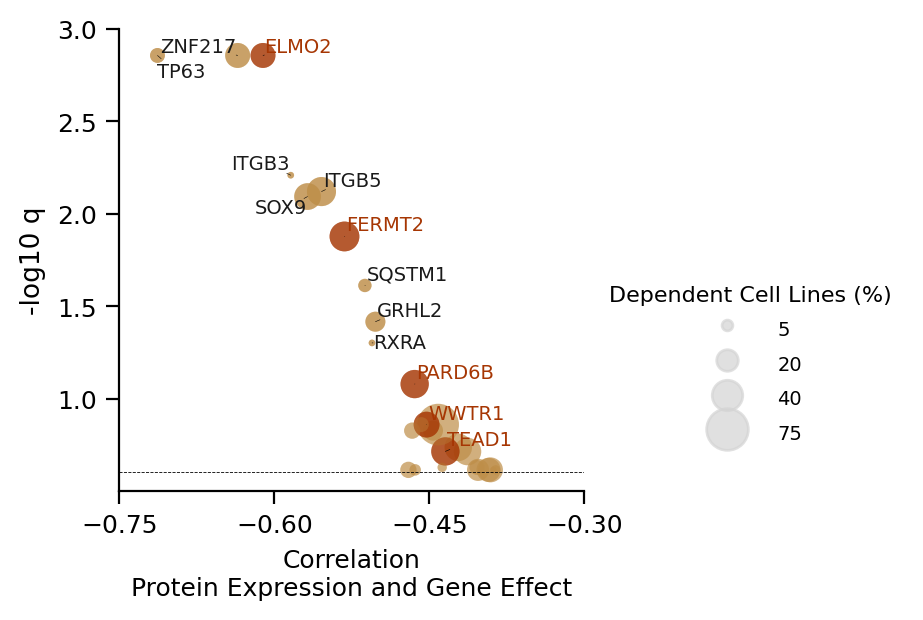

In [24]:
selected_genes_dic = {'WWTR1':'#a63603', 'TEAD1':'#a63603', 'PAR6B':'#a63603', 'FERM2':'#a63603', 'ELMO2':'#a63603'} #PPP1CA #'PARD6B'  'PP1A':'#a63603',
Utils.statistical_test_and_volcano_plot_v2(proteomics_mad_filtered_df2, gene_effect_filtered_df2, size_scale=300, points_size=info_df2['hit_rate'], points_labels_sr=info_df2['gene_name'], near_sig_qval=0.25, y_thr_qval=0.25, x_thr_leq=-0.25, selected_genes_dic=selected_genes_dic, test='correlation', xlabel='Correlation\nProtein Expression and Gene Effect', cut_off_labels=15,  force_points=1, force_text=1, save_file='gene_effect_protein_corr_40percent.csv', up_regulated=False, ylim_top=3, ytick_step=.5, xlim_right=-0.3, xlim_left=-.75, xtick_step=.15, xlabel_fontsize=9, ylabel_fontsize=9.5, add_legend=True, legend_title='Dependent Cell Lines (%)', hline_sig_cutoff=0.25, near_sig_color_down='#BE8E48', sig_color_down='#BE8E48', save_figure=True, legend_num=[5,20,40,75])#labels_sr=info_df['gene_name'],

In [25]:
res_file = 'Figure6/output_fig6/gene_effect_protein_corr_40percent.csv'
res_df = pd.read_csv(res_file, index_col=0)
res_df = res_df.sort_values('corr', ascending=False).sort_values('q-value', ascending=True)
res_df['GeneName'] = protein_gene_mapping_df.loc[res_df.index, 'GeneName']
res_df = res_df[['GeneName', 'corr', 'p-value', 'q-value']]
MyLib.save_csv(res_df, 'gene_effect_protein_corr_40percent.csv')


File  Figure6/output_fig6/gene_effect_protein_corr_40percent.csv saved, shape: (1906, 4)


# EGFR

In [26]:
egfr_dep_rna_cor_file = 'Figure3/output_fig3/egfr_rna_corr.csv'
egfr_dep_rna_cor_df = pd.read_csv(egfr_dep_rna_cor_file, index_col=0)
egfr_dep_rna_cor_df = egfr_dep_rna_cor_df[(egfr_dep_rna_cor_df['p-value']<0.05)]#(egfr_dep_rna_cor_df['corr']<0) &
egfr_dep_rna_cor_df

,feature,corr,p-value,q-value
Gene,,,,
ETV5,ETV5,0.589253,0.000124,0.257512
TWF2,TWF2,0.549640,0.000426,0.508522
MMP11,MMP11,0.525705,0.000833,0.522403
KDM8,KDM8,0.512113,0.001195,0.574887
HEATR3,HEATR3,0.506308,0.001387,0.579563
...,...,...,...,...
GABRP,GABRP,-0.617339,0.000047,0.164991
HYAL4,HYAL4,-0.644789,0.000017,0.072414
FAM25C,FAM25C,-0.650179,0.000013,0.072414


In [27]:
upset_df = raw_upset_df[(raw_upset_df['Protein']==1) & (raw_upset_df['CRISPR']==1) & (raw_upset_df['Subtype']!='HCC')]
btc_gene_effect_df = raw_gene_effect_df.loc[raw_gene_effect_df.index.isin(upset_df.index)]
btc_gene_effect_df.shape

(37, 17787)

In [28]:
btc_proteomics_filtered_df, gene_effect_filtered_df = Utils.match_rows_df(raw_proteomics_df, btc_gene_effect_df)
btc_proteomics_filtered_df = Clustering.filter_sparse_samples(btc_proteomics_filtered_df, max_allowed_nans_zeros_frac=0.4)
btc_proteomics_mad_filtered_df = btc_proteomics_filtered_df.apply(Clustering.mad_normalize)
btc_proteomics_mad_filtered_df.shape

(37, 8812)

Select proteins whose RNA is nominally significant genes in correlation with EGFR depenedency

In [29]:
protein_gene_mapping_rna_filtered_df = protein_gene_mapping_df[protein_gene_mapping_df['GeneName'].isin(egfr_dep_rna_cor_df.index)]
btc_proteomics_mad_rna_filtered_df = btc_proteomics_mad_filtered_df.loc[:, btc_proteomics_mad_filtered_df.columns.isin(protein_gene_mapping_rna_filtered_df.index)]
btc_proteomics_mad_rna_filtered_df.shape

(37, 531)

In [30]:
egfr_gene_effect_sr = gene_effect_filtered_df.sort_values(by='EGFR')['EGFR'].sort_values()
cut_off_index = 10
egfr_dependent_l = egfr_gene_effect_sr.index.tolist()[0:cut_off_index]
print(len(egfr_dependent_l))
egfr_non_dep_l = egfr_gene_effect_sr.index.tolist()[-cut_off_index:]
print(len(egfr_non_dep_l))

10
10


In [31]:
egfr_gene_effect_sr

ICC10-8     -2.006659
KMCH1       -1.655066
HUCCT1      -1.471054
SNU478      -1.296188
ECC3        -1.270041
OCUG1       -1.229622
GB2         -1.199765
HKGZCC      -1.052255
TGBC1TKB    -1.043033
ICC4        -0.967263
ICC9        -0.928587
ICC2        -0.838486
ICC10       -0.819308
TKKK        -0.807539
ICC10-6     -0.783723
AOVC1       -0.777736
TGBC52TKB   -0.776630
TFK1        -0.624075
SNU1196     -0.617907
RBE         -0.576848
YSCCC       -0.575871
EGI1        -0.570605
SSP25       -0.542457
CCSW1       -0.434212
KKU213      -0.411525
KKU100      -0.371286
SNU308      -0.348042
SNU1079     -0.339373
SNU869      -0.334542
ICC13-7     -0.328221
ICC12       -0.285665
G415        -0.280190
SG231       -0.275322
ECC4        -0.250662
ICC8        -0.194467
CCLP1       -0.141224
NOZ         -0.090710
Name: EGFR, dtype: float64

In [32]:
egfr_dependent_l

['ICC10-8',
 'KMCH1',
 'HUCCT1',
 'SNU478',
 'ECC3',
 'OCUG1',
 'GB2',
 'HKGZCC',
 'TGBC1TKB',
 'ICC4']

In [33]:
Utils.statistical_test_and_volcano_plot(btc_proteomics_mad_rna_filtered_df.loc[egfr_dependent_l], btc_proteomics_mad_rna_filtered_df.loc[egfr_non_dep_l], test='ranksum', xlabel='Effect Size', q_value=0.25, cut_off_labels=5, force_points=13, force_text=8,  save_file=f'egfr_dep_proteins_features.csv', plot_qqplot=False, plot_volcano=False)


File  Figure6/output_fig6/egfr_dep_proteins_features.csv saved, shape: (531, 7)


,feature,stat,p-value,effect_size,q-value,in_group_mean,out_group_mean
0,HLTF,-3.099309,0.001940,-0.693026,0.196956,-1.943774,1.774764
1,MICA1,-3.023716,0.002497,-0.676123,0.196956,-0.599116,1.419276
2,BACH,-3.023716,0.002497,-0.676123,0.196956,-0.819557,1.144597
3,RNF14,-2.982976,0.002855,-0.667014,0.196956,-0.751968,1.207631
4,KTNB1,-2.872530,0.004072,-0.642317,0.196956,-1.121276,1.167929
...,...,...,...,...,...,...,...
526,HERC6,2.730546,0.006323,0.610569,0.196956,1.222577,-0.878158
527,LRRC1,2.796937,0.005159,0.625414,0.196956,0.881716,-1.876802
528,CF132,2.796937,0.005159,0.625414,0.196956,0.605866,-2.518087
529,SMBP2,2.948123,0.003197,0.659220,0.196956,1.516265,-0.778233


In [34]:
res_file = 'Figure6/output_fig6/egfr_dep_proteins_features.csv'
res_df = pd.read_csv(res_file, index_col=0)
res_df.set_index('feature', inplace=True)
res_df.index.name = 'ProteinID'
res_df['GeneName'] = protein_gene_mapping_df.loc[res_df.index]['GeneName'].values
res_df = res_df[['GeneName'] + [c for c in res_df.columns if c != 'GeneName']]
MyLib.save_csv(res_df, 'egfr_dep_proteins_features.csv')


File  Figure6/output_fig6/egfr_dep_proteins_features.csv saved, shape: (531, 7)


In [35]:
res_df[res_df['GeneName']=='WWTR1'] # Near-significance

,GeneName,stat,p-value,effect_size,q-value,in_group_mean,out_group_mean
ProteinID,,,,,,,
WWTR1,WWTR1,-2.075101,0.037977,-0.464007,0.206405,-0.881118,0.774346


# Dependency Analysis for Clusters

Number of cell lines in each cluster

In [36]:
protein_upset_df['Cluster'].value_counts()

P1    20
P3    17
P2    14
P5    13
P4    11
Name: Cluster, dtype: int64

Number of cell lines with CRISPR data in each cluster

In [37]:
protein_CRISPR_upset_df['Cluster'].value_counts()


P1    13
P5    13
P3    11
P2    10
P4     5
Name: Cluster, dtype: int64

In [38]:
gene_effect_df = gene_effect_df.loc[protein_CRISPR_upset_df.index]
gene_effect_df.shape

(52, 15308)

## Explore genes with different properties

In [39]:
var_df = Clustering.select_top_variable_features(gene_effect_df, top_k=100)
var_df.shape

(52, 100)

In [40]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])
threshold = np.percentile(lrt_df['lrt'].dropna(), 98)

genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['name'].tolist() if g in gene_effect_df.columns]
gene_effect_lrt_df = gene_effect_df[genes_lrt_l]
gene_effect_lrt_df.shape

input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



(52, 193)

In [41]:
cosmic_file = 'Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv'
cosmic_df = MyLib.load_csv(cosmic_file, index_col=0)

cosmic_df = cosmic_df[cosmic_df['Hallmark'] == 'Yes']
hallmark_l = cosmic_df.index.tolist()
hallmark_l = sorted(set(hallmark_l).intersection(gene_effect_df.columns.tolist()))
len(hallmark_l)

input_data/Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv  is loaded, shape:  (743, 19)



291

(291,)


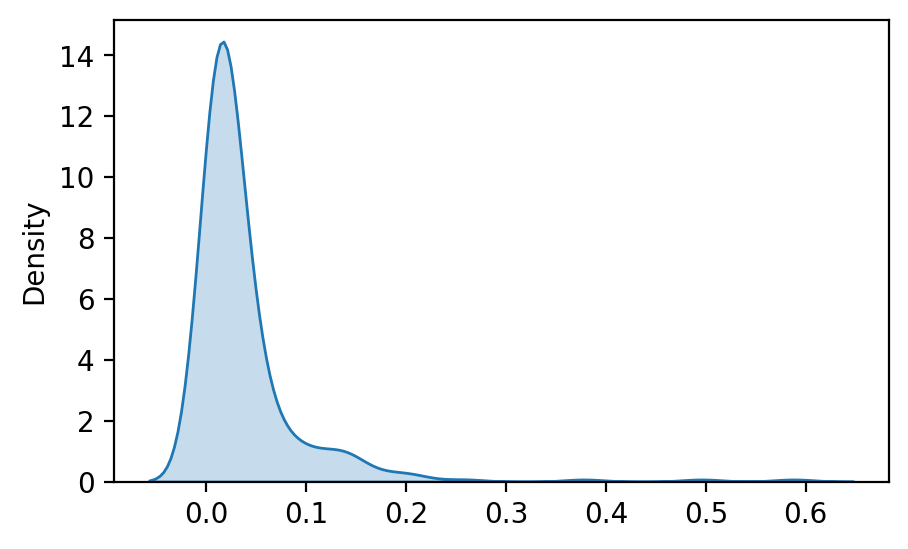

In [42]:
var_sr = gene_effect_df[hallmark_l].var(axis=0)
print(var_sr.shape)
MyVisualization.plot_distribution(var_sr)

In [43]:
hm_df = Clustering.drop_low_vars(gene_effect_df[hallmark_l], threshold=0.1)
# hm_df = Clustering.select_top_variable_features(gene_effect_filtered_df[hallmark_l], top_k=60)
hm_df.shape

(52, 26)

In [44]:
pref_file = 'Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv'
pref_l = MyLib.load_csv(pref_file, index_col=0).index.tolist()
pref_l = [g for g in pref_l if g in gene_effect_df.columns]
len(pref_l)

input_data/Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv  is loaded, shape:  (696, 1)



620

In [45]:
genes_l = sorted(set(pref_l).union(var_df.columns.tolist()).union(set(hm_df.columns)).union(gene_effect_lrt_df.columns))  # 
gene_effect_filtered_df = gene_effect_df[genes_l].copy()

gene_effect_filtered_df.shape

(52, 766)

## Select significant dependencies

In [46]:
volcano_axes_lim_dic= {'P1':(5,None, 2,None, None, None), 'P2':(2.5,None, 2,None, None, None), 'P3':(None,None, None,None, None, None),'P4':(3, None, 2,None, None, None),'P5':(2.5,None, 2,None, None, None) }

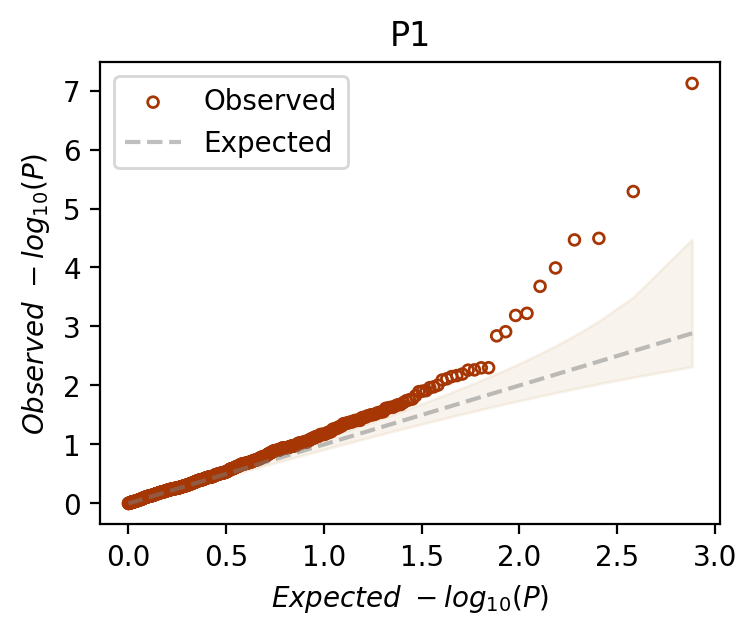


File  Figure6/output_fig6/dependency_hits_all_P1_features_Down.csv saved, shape: (7, 6)


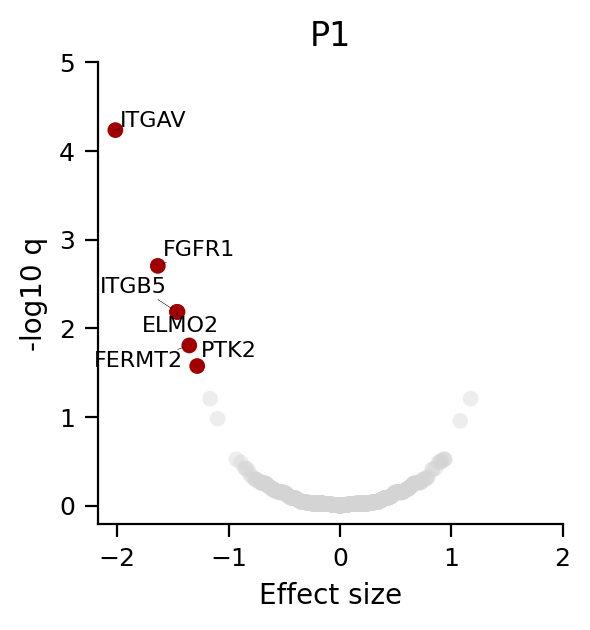


File  Figure6/output_fig6/dependency_hits_P1_features_Down_dep_hits.csv saved, shape: (6, 5)

File  Figure6/output_fig6/dependency_hits_P1_features_Down.csv saved, shape: (7, 5)


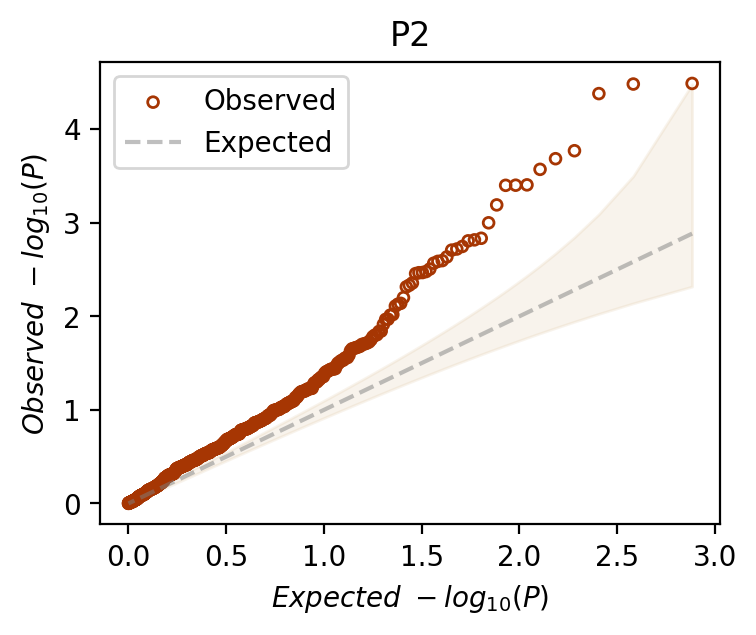


File  Figure6/output_fig6/dependency_hits_all_P2_features_Down.csv saved, shape: (16, 6)


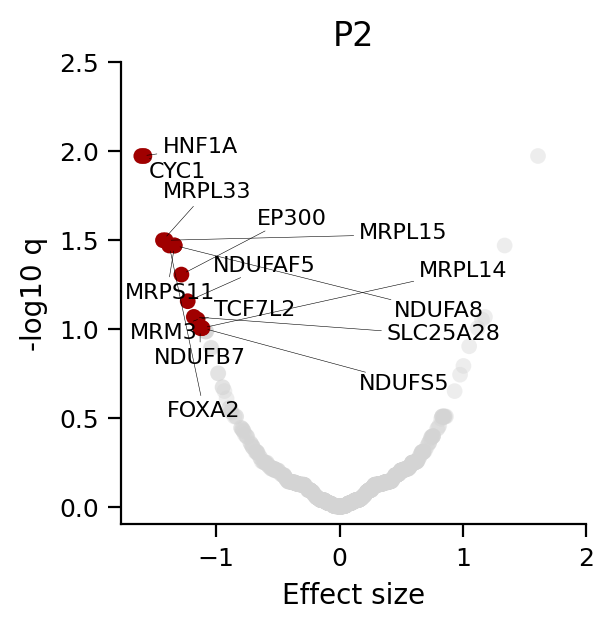


File  Figure6/output_fig6/dependency_hits_P2_features_Down_dep_hits.csv saved, shape: (15, 5)

File  Figure6/output_fig6/dependency_hits_P2_features_Down.csv saved, shape: (16, 5)


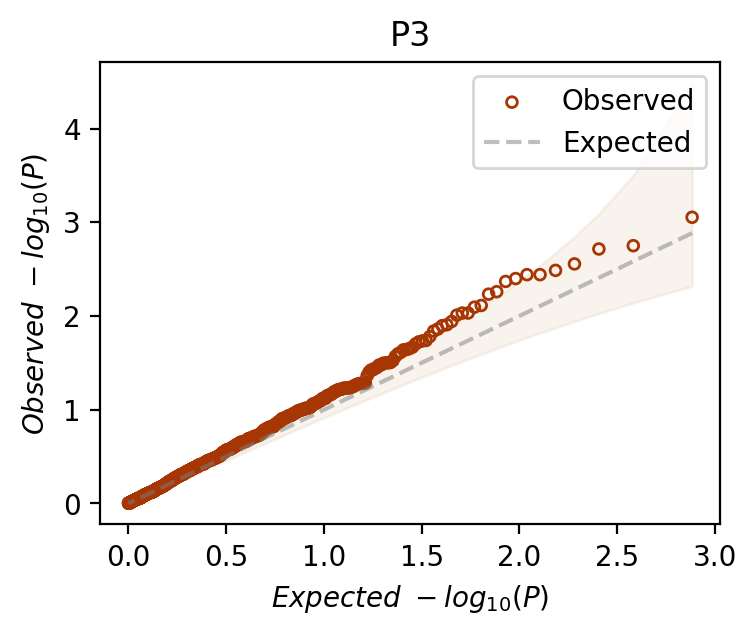

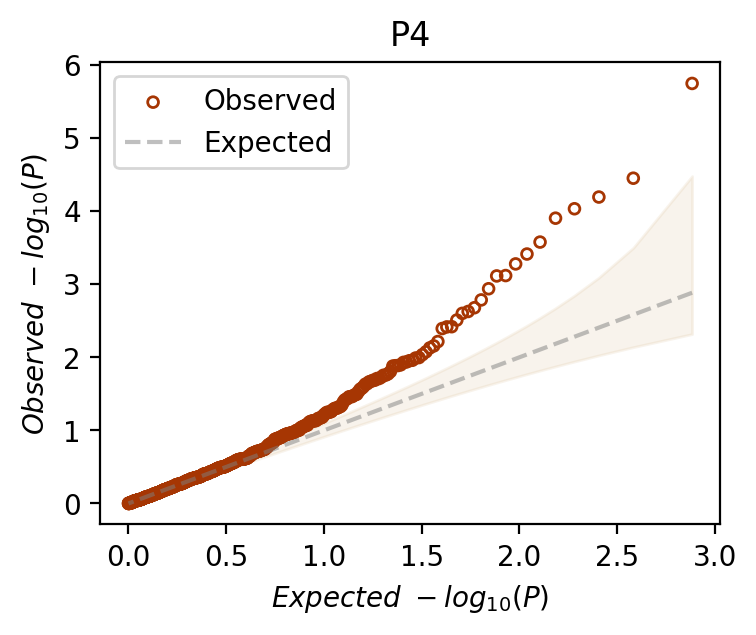


File  Figure6/output_fig6/dependency_hits_all_P4_features_Down.csv saved, shape: (11, 6)


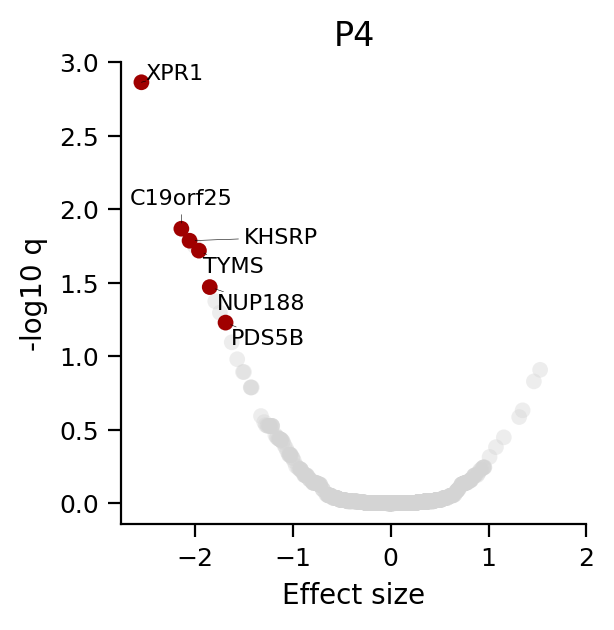


File  Figure6/output_fig6/dependency_hits_P4_features_Down_dep_hits.csv saved, shape: (6, 5)

File  Figure6/output_fig6/dependency_hits_P4_features_Down.csv saved, shape: (11, 5)


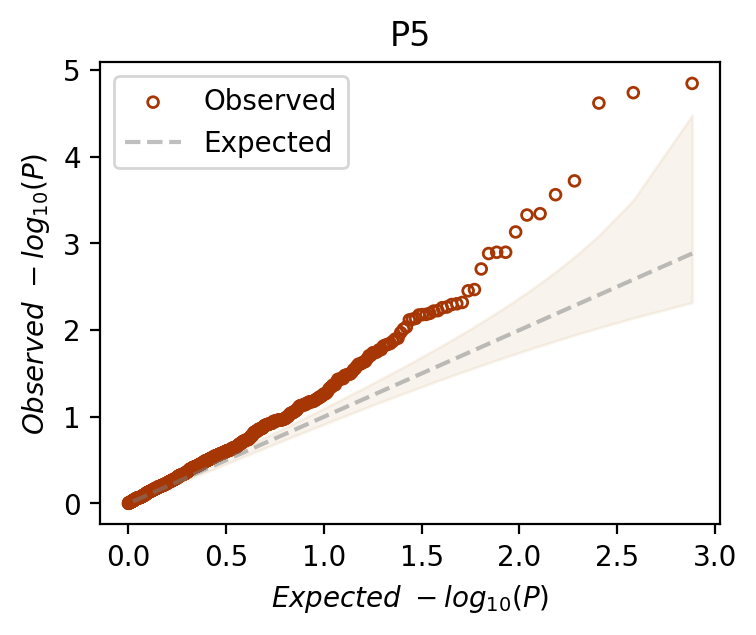


File  Figure6/output_fig6/dependency_hits_all_P5_features_Down.csv saved, shape: (9, 6)


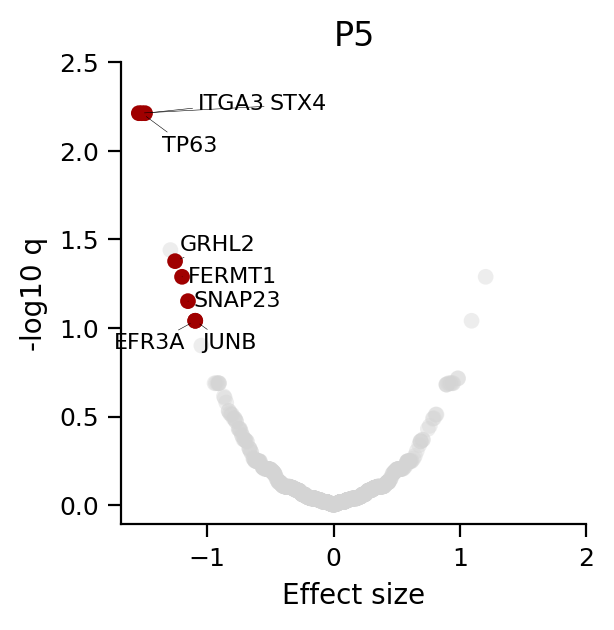


File  Figure6/output_fig6/dependency_hits_P5_features_Down_dep_hits.csv saved, shape: (8, 5)

File  Figure6/output_fig6/dependency_hits_P5_features_Down.csv saved, shape: (9, 5)


In [47]:
features = Clustering.identify_significant_features(gene_effect_filtered_df.loc[protein_CRISPR_upset_df.index], protein_CRISPR_upset_df, up_regulated=False, ttest=True, cluster_column='Cluster', q_val_thr=0.1, force_points=3.2, force_text=1.1, volcano_axes_lim_dic=volcano_axes_lim_dic, gene_effect_thr=-0.5, save_figure=True, cut_off_labels_top=20, filter=True, add_mean_cols=True, filename_prefix='dependency_hits_')